# USS assets 
## historic growth 1992-2021 
## forecast growth from discount rates 2011, 14, 17, 20 and 21

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as sta
import csv

In [2]:
import uss_pensions as up

ONS data loading:
Annual CPI change, monthly, as array             cpi_annual_monthly_ons
Annual CPI change, annually, as array            cpi_annual_annually_ons
Annual CPI change, annually Jan-Jan, as array    cpi_annual_jan_jan_ons
Annual CPI index (2015=1.00), monthly, as array  cpi_index_monthly_ons

USS historic assets and investment growth data loading:
Assets (nominal, B GBP) from annual report       assets_nom
Investment returns (nominal basis)               inv_ret_nom
Estimating USS assets from investment returns, normalised to nominal assets in year 2020.25:
Stored in array:                                 cum_inv_ret_nom_2020
Converting reported assets and estimated assets to CPI basis, base year 2020.25:
Reported assets CPI stored in array:            assets_reported_cpi_2020
Estimated assets CPI stored in array:            assets_inv_ret_cpi_2020
*** Note 1: assets are estimated using investment returns, with reported assets at 2020 as the basis
*** Note 2: they are esti

In [3]:
print("CPI2015.5 index at last assets report date", up.get_cpi_index_ons(up.assets_nom[-1,0], 2015.5)[0,1])
print("CPI2015.5 index applied to assets         ", (up.assets_nom[-1,:]/up.get_cpi_adjusted(up.assets_nom, 2015.5)[-1,:])[1])

CPI2015.5 index at last assets report date 1.121378179721764
CPI2015.5 index applied to assets          1.121378179721764


In [4]:
# To choose whether to save plots and data, set the following to True or False
save_plots = True
save_data = True

## USS asset projections with "prudent" discount rates

In [5]:
# Assemble dictionary of projected assets estimated from USS prudent discount rates

proj_assets_prud_cpi_2020 = {}
end_year = 2068

skip_list = ['2017a', '2019', '2020b', '2021b']

for val in up.valuation_list:
    if val not in skip_list:
        year = int(val[:4])
        y = np.arange(year + 1, end_year)
        assets_start = up.get_assets_cpi_reported(year+0.25)[0,1]
        assets = np.stack((y, np.ones_like(y)*assets_start), axis=1)
        disc_rates = up.get_cum_disc_uss_cpi(y, val)
        assets[:,1] /= disc_rates[:,1]
        proj_assets_prud_cpi_2020[val] = assets
        print(f'Assets projected with "prudent" discount rate for valuation {val:}')


Assets projected with "prudent" discount rate for valuation 2011
Assets projected with "prudent" discount rate for valuation 2014
Assets projected with "prudent" discount rate for valuation 2017b
Assets projected with "prudent" discount rate for valuation 2018
Assets projected with "prudent" discount rate for valuation 2020a
Assets projected with "prudent" discount rate for valuation 2021a


Let's calculate what this "prudent" estimate of growth gives for the annualised growth rate over the next 30 years.

In [6]:
ann_30_prud_grow_rate = {}

for val in up.disc_prud_cpi_dict:
    ann_30_prud_grow_rate[val] = up.get_annualised_growth_rate(up.disc_prud_cpi_dict[val])
    print('USS "prudent" ' + f'{val:5s}' + " 30-year annualised growth rate (CPI basis): {:.2f} %".format(100*ann_30_prud_grow_rate[val]))

USS "prudent" 2011  30-year annualised growth rate (CPI basis): 3.50 %
USS "prudent" 2014  30-year annualised growth rate (CPI basis): 2.21 %
USS "prudent" 2017a 30-year annualised growth rate (CPI basis): 1.15 %
USS "prudent" 2017b 30-year annualised growth rate (CPI basis): 0.97 %
USS "prudent" 2018  30-year annualised growth rate (CPI basis): 1.11 %
USS "prudent" 2019  30-year annualised growth rate (CPI basis): 0.92 %
USS "prudent" 2020a 30-year annualised growth rate (CPI basis): 0.20 %
USS "prudent" 2020b 30-year annualised growth rate (CPI basis): 0.29 %
USS "prudent" 2021a 30-year annualised growth rate (CPI basis): -0.06 %
USS "prudent" 2021b 30-year annualised growth rate (CPI basis): 0.20 %


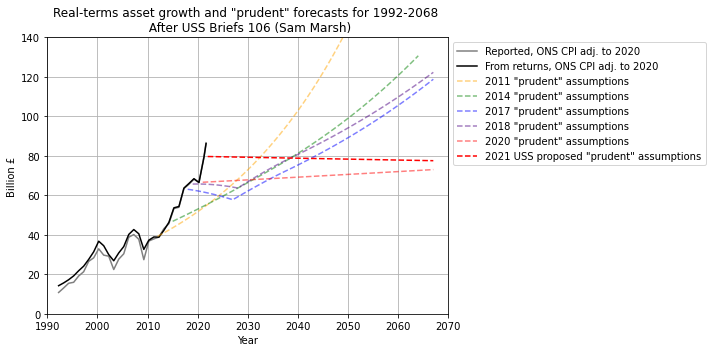

In [7]:
plt.figure(figsize=(10,5))

plt.plot(up.assets_reported_cpi_2020[:,0], up.assets_reported_cpi_2020[:,1], 
         color=(0.5,0.5,0.5), 
         label='Reported, ONS CPI adj. to 2020')

plt.plot(up.assets_inv_ret_cpi_2020[:,0], up.assets_inv_ret_cpi_2020[:,1], 
         color='k', 
         label='From returns, ONS CPI adj. to 2020')

col_list = ['orange', 'g', 'b', 'indigo', 'r', 'r']
alpha_list = [0.5]*5 + [1]
ls_list = ['--']*6
lab_list = ['{:} "{:}" assumptions']*5 +\
            ['{:} USS proposed "{:}" assumptions']

dp = {}
for val, col, al, ls, lab in zip(proj_assets_prud_cpi_2020, col_list, alpha_list, ls_list, lab_list):
    dp[val] = {"color" : col, "alpha" : al, "ls" : ls, "label" : lab}
    

for val in proj_assets_prud_cpi_2020:
    plt.plot(proj_assets_prud_cpi_2020[val][:,0], proj_assets_prud_cpi_2020[val][:,1], 
             color=dp[val]["color"], 
             ls=dp[val]["ls"], 
             alpha=dp[val]["alpha"], 
             label=dp[val]["label"].format(val[0:4], 'prudent'))



plt.xlim(1990,2070)
plt.ylim(0,140)

plt.title('Real-terms asset growth and "prudent" forecasts for 1992-2068 \n After USS Briefs 106 (Sam Marsh)')
plt.xlabel('Year')
plt.ylabel('Billion £ (CPI adjusted to end March 2020)')


plt.grid()
plt.legend(bbox_to_anchor=(1.0, 0.0, .1, 1))

plt.tight_layout()
if save_plots:
    plt.savefig("uss_assets_and_prudent_forecasts.pdf")

In [8]:
if save_data:
    fn_inv_ret_cpi = '1992_2021_assets_from_investment_returns_cpi_2020.csv'
    fn_reported_cpi = '1992_2021_assets_reported_cpi_2020.csv'

    field = 'Assets value (B GBP, CPI 2020)'
    
    up.write_csv(fn_inv_ret_cpi, field, up.assets_inv_ret_cpi_2020 )
    up.write_csv(fn_reported_cpi, field, up.assets_reported_cpi_2020 )



Array of Assets value (B GBP, CPI 2020) written to file 1992_2021_assets_from_investment_returns_cpi_2020.csv
Array of Assets value (B GBP, CPI 2020) written to file 1992_2021_assets_reported_cpi_2020.csv


## USS asset projections with "best estimate" discount rates

In [9]:
# Assemble dictionary of projected assets estimated from USS "best estimate" discount rates
end_year = 2068
proj_assets_best_cpi_2020 = {}

for val in up.disc_best_cpi_dict:
        year = int(val[:4])
        y = np.arange(year + 1, end_year)
        assets_start = up.get_assets_cpi_reported(year+0.25)[0,1]
        assets = np.stack((y, np.ones_like(y)*assets_start), axis=1)
        disc_rates = up.get_cum_disc_uss_cpi(y, val, up.disc_best_cpi_dict)
        assets[:,1] /= disc_rates[:,1]
        proj_assets_best_cpi_2020[val] = assets
        print(f'Assets projected with "best estimate" discount rate for valuation {val:}')


Assets projected with "best estimate" discount rate for valuation 2017b
Assets projected with "best estimate" discount rate for valuation 2018
Assets projected with "best estimate" discount rate for valuation 2020a
Assets projected with "best estimate" discount rate for valuation 2021a


### Fit historic asset growth
Here we fit the historic asset growth to an exponential function, defined in the `uss_pensions` module as `growth_function`. 

In [10]:
# Fitting

a_init = 0.05
A0_init = 66

pars, cov = opt.curve_fit(up.growth_function, 
                          up.assets_inv_ret_cpi_2020[:,0], up.assets_inv_ret_cpi_2020[:,1],
                         (a_init, A0_init))

a = pars[0]
A0 = pars[1]

print()
print(f"Historic USS asset annual growth rate 1992-2021 (CPI basis): {a*100:.1f} %") 
print()



Historic USS asset annual growth rate 1992-2021 (CPI basis): 5.1 %



Now we compare the historic asset growth to the "best estimates" produced by USS at recent valuations. First, the 30-year annualised growth rates.

In [11]:
ann_30_best_grow_rate = {}

for val in up.disc_best_cpi_dict:
    ann_30_best_grow_rate[val] = up.get_annualised_growth_rate(up.disc_best_cpi_dict[val])
    print('USS "best estimate" ' + f'{val:5s}' + \
          " 30-year annualised growth rate (CPI basis): {:.2f} %".format(100*ann_30_best_grow_rate[val]))

USS "best estimate" 2017b 30-year annualised growth rate (CPI basis): 2.17 %
USS "best estimate" 2018  30-year annualised growth rate (CPI basis): 2.25 %
USS "best estimate" 2020a 30-year annualised growth rate (CPI basis): 1.70 %
USS "best estimate" 2021a 30-year annualised growth rate (CPI basis): 1.00 %


In [12]:
for val in up.disc_best_cpi_dict:
    print('USS "prudent" ' + f'{val:5s}' + \
          " 30-year annualised growth rate (CPI basis): {:.2f} %".format(100*ann_30_prud_grow_rate[val]))

USS "prudent" 2017b 30-year annualised growth rate (CPI basis): 0.97 %
USS "prudent" 2018  30-year annualised growth rate (CPI basis): 1.11 %
USS "prudent" 2020a 30-year annualised growth rate (CPI basis): 0.20 %
USS "prudent" 2021a 30-year annualised growth rate (CPI basis): -0.06 %


In [13]:
# Prepare to plot historic fit and project into the future

years_past = up.assets_inv_ret_cpi_2020[:,0]
assets_best_fit_past = up.growth_function(years_past, *pars)
years_future = np.arange(2022, end_year)
assets_best_fit_future = up.growth_function(years_future, *pars)

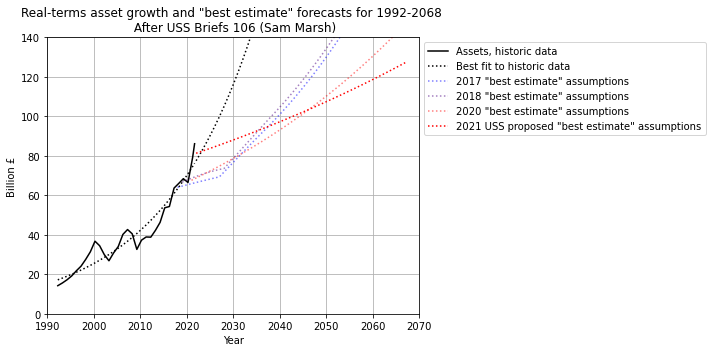

In [15]:
plt.figure(figsize=(10,5))

# plt.plot(assets_cpi_2020[:,0], assets_cpi_2020[:,1], 
#          color=(0.5,0.5,0.5), 
#          label='Reported, ONS CPI adj. to 2020')

plt.plot(up.assets_inv_ret_cpi_2020[:,0], up.assets_inv_ret_cpi_2020[:,1], 
         color='k', 
         label='Assets, historic data')

plt.plot(years_past, assets_best_fit_past, 
         color='k', ls=':')

plt.plot(years_future, assets_best_fit_future, 
         color='k', ls=':',
         label='Best fit to historic data')

# Dash-dot for best estimates
db = dp.copy()
for val in db:
    db[val]["ls"] = ':'
#db['2021a']["ls"] = '-'
    
for val in proj_assets_best_cpi_2020:
    plt.plot(proj_assets_best_cpi_2020[val][:,0], proj_assets_best_cpi_2020[val][:,1], 
             color=db[val]["color"], 
             ls=db[val]["ls"], 
             alpha=db[val]["alpha"], 
             label=db[val]["label"].format(val[0:4], 'best estimate'))

#plt.yscale('log')
plt.xlim(1990,2070)
plt.ylim(0,140)

plt.title('Real-terms asset growth and "best estimate" forecasts for 1992-2068 \n After USS Briefs 106 (Sam Marsh)')
plt.xlabel('Year')
plt.ylabel('Billion £ (CPI adjusted to end March 2020)')

plt.grid()
plt.legend(bbox_to_anchor=(1.0, 0.0, .1, 1))

plt.tight_layout()
if save_plots:
    plt.savefig("uss_assets_best_est.pdf")

## Appendix: calculation of cumulative returns

USS changed the dates at which they record the returns on investments in 2015, which means the data is not regularly spaced.  This then means that the calculation of cumulative returns is not straightforward. This appendix shows how it is done.

Suppose we have a set of annual return rates $r_i$ recorded at times $t_i$, starting at time $t_0$. If the times are regular spaced at intervals of one year, the calculation of the cumulative return over a set of $N$ observations - the growth factor $G(t_N, t_0)$ - would be easy:
$$
G(t_N, t_0) = \prod_{i=1}^{N} ( 1 + r_i).
$$
However, if the times at which the annual growth rates are not regularly spaced, one has to make some assumption about how to calculate the growth that actually happened between the dates of the records.  We assume that the growth can be interpolated between records by taking the geometric mean, weighted by the time interval, so if the annual return rate $r_i$ is recorded after an interval $\Delta t_i = t_i - t_{i-1}$, the the growth factor that occurred in that interval was 
$$
G(t_i, t_{i-1}) = ( 1 + r_i)^{\Delta t_i}.
$$
where we have taken the time to be recorded in units of years (taken as decimal numbers, and without worrying about exactly which kind of year).

Then the growth factor formula is generalised to 
$$
G(t_N, t_0) = \prod_{i=1}^{N} ( 1 + r_i)^{\Delta t_i}.
$$
In practice, we calculate the product as an exponential of a sum of logarithms,
$$
G(t_N, t_0) = \exp \left (\sum_{i=1}^{N} {\Delta t_i} \ln( 1 + r_i) \right).
$$
This is the formula implemented in `uss_pensions.prod_by_sum_of_logs`, which is used in the function `cum_inv_ret_nom`.